<a href="https://colab.research.google.com/github/sujitojha1/EVA8/blob/main/Session4/EVA8_S4_step1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Step 1
### Target
1. Create a Setup (dataset, data loader, train/test steps and log plots)
2. Defining simple model with Convolution block, GAP.


In [51]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations


In [52]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [53]:
train = datasets.MNIST('./data', train=True, download = True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

## Dataloader Arguments & Test/Train Dataloaders

In [54]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Availalbe?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments
dataloader_args = dict(shuffle=True,batch_size=128,num_workers=4,pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Availalbe? True


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Model

In [62]:
import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 8

        # TRANSITION BLOCK 2
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(1, 1), padding=1, bias=False),
        ) # output_size = 8
        self.pool2 = nn.MaxPool2d(2, 2) # output_size = 4

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 2
        
        # # OUTPUT BLOCK
        # self.gap = nn.Sequential(
        #     nn.AvgPool2d(kernel_size=6)
        # ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 

        self.fc = nn.Sequential(
            nn.Linear(90, 10)
        )

        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.pool2(x)
        x = self.convblock7(x)
        # x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(x.size(0),-1)
        x = self.fc(x)
        return F.log_softmax(x, dim=-1)

## Model Params

In [63]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]             128
        MaxPool2d-10            [-1, 8, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,152
             ReLU-12           [-1, 16, 10, 10]               0

## Training and Testing

In [64]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss.item())

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [65]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loss=0.1209685429930687 Batch_id=468 Accuracy=90.42: 100%|██████████| 469/469 [00:18<00:00, 25.13it/s]



Test set: Average loss: 0.0673, Accuracy: 9779/10000 (97.79%)

EPOCH: 1


Loss=0.05804954841732979 Batch_id=468 Accuracy=97.14: 100%|██████████| 469/469 [00:14<00:00, 32.74it/s]



Test set: Average loss: 0.0449, Accuracy: 9861/10000 (98.61%)

EPOCH: 2


Loss=0.028238333761692047 Batch_id=468 Accuracy=97.69: 100%|██████████| 469/469 [00:13<00:00, 33.80it/s]



Test set: Average loss: 0.0440, Accuracy: 9860/10000 (98.60%)

EPOCH: 3


Loss=0.04036079719662666 Batch_id=468 Accuracy=97.93: 100%|██████████| 469/469 [00:14<00:00, 33.36it/s]



Test set: Average loss: 0.0355, Accuracy: 9888/10000 (98.88%)

EPOCH: 4


Loss=0.01878034509718418 Batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:13<00:00, 33.99it/s]



Test set: Average loss: 0.0298, Accuracy: 9898/10000 (98.98%)

EPOCH: 5


Loss=0.09718292206525803 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:14<00:00, 33.07it/s]



Test set: Average loss: 0.0286, Accuracy: 9909/10000 (99.09%)

EPOCH: 6


Loss=0.010736948810517788 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:13<00:00, 33.64it/s]



Test set: Average loss: 0.0311, Accuracy: 9897/10000 (98.97%)

EPOCH: 7


Loss=0.0868484303355217 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:13<00:00, 33.85it/s]



Test set: Average loss: 0.0290, Accuracy: 9903/10000 (99.03%)

EPOCH: 8


Loss=0.049218419939279556 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:14<00:00, 32.46it/s]



Test set: Average loss: 0.0249, Accuracy: 9921/10000 (99.21%)

EPOCH: 9


Loss=0.042150527238845825 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:13<00:00, 33.91it/s]



Test set: Average loss: 0.0248, Accuracy: 9919/10000 (99.19%)

EPOCH: 10


Loss=0.0040415008552372456 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:13<00:00, 33.97it/s]



Test set: Average loss: 0.0251, Accuracy: 9921/10000 (99.21%)

EPOCH: 11


Loss=0.0025037077721208334 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:14<00:00, 31.62it/s]



Test set: Average loss: 0.0266, Accuracy: 9922/10000 (99.22%)

EPOCH: 12


Loss=0.09132348746061325 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:13<00:00, 34.53it/s]



Test set: Average loss: 0.0237, Accuracy: 9921/10000 (99.21%)

EPOCH: 13


Loss=0.059411149471998215 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:13<00:00, 34.73it/s]



Test set: Average loss: 0.0245, Accuracy: 9920/10000 (99.20%)

EPOCH: 14


Loss=0.07355133444070816 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:13<00:00, 33.84it/s]



Test set: Average loss: 0.0245, Accuracy: 9925/10000 (99.25%)



Text(0.5, 1.0, 'Test Accuracy')

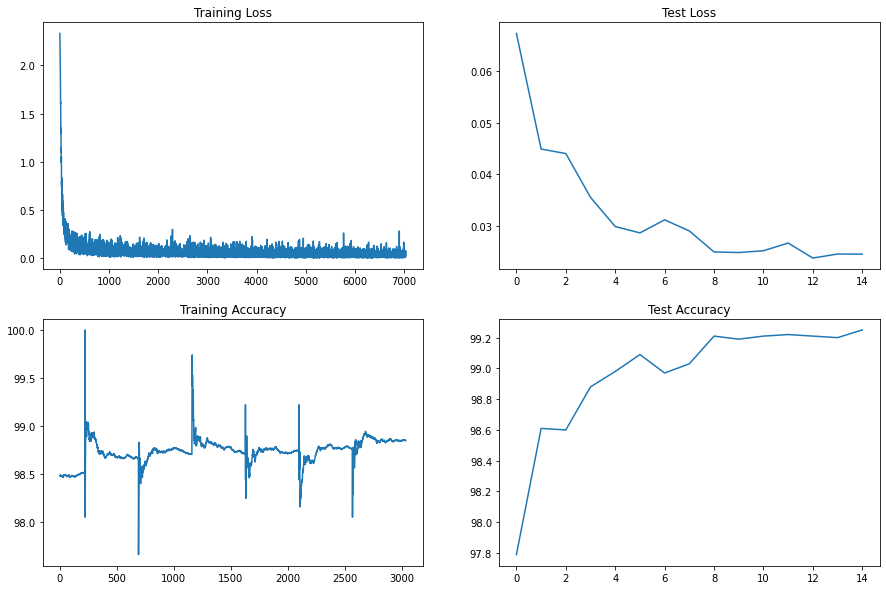

In [66]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")